In [113]:
import numpy as np
from smt.surrogate_models import KRG
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


In [114]:
# Load data
df = pd.read_csv('Monte_Carlo_10000/training_data_crushing.csv')

In [115]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = df[['mean_force']].values

In [116]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [117]:
poly_values = ['constant', 'linear', 'quadratic']
corr_values = ['pow_exp', 'abs_exp', 'squar_exp', 'matern52', 'matern32']

MAPE, for KRG: 0.67 %
Corr: abs_exp
Poly: linear


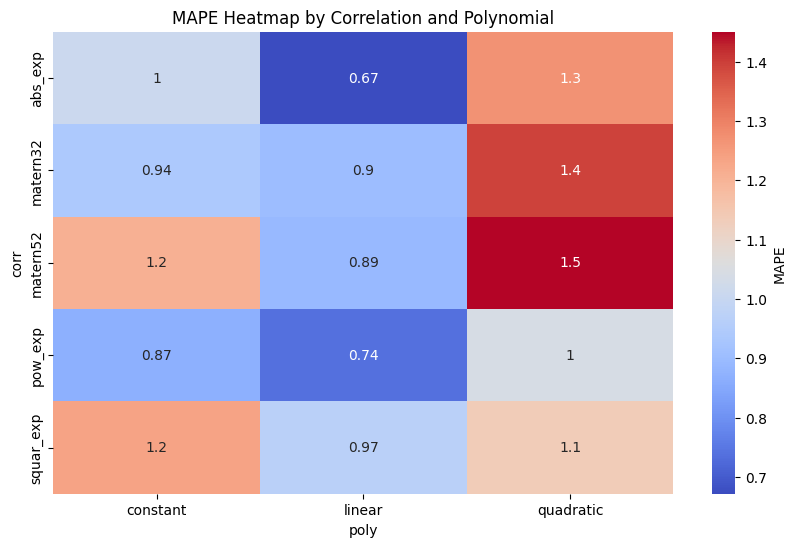

In [121]:
values = []
for ploy in poly_values:
    for corr in corr_values:
        KRG_model = KRG(
            corr=corr,
            poly=ploy, 
            print_global=False
        )
        KRG_model.set_training_values(X_train, Y_train)
        KRG_model.train()
        Y_pred = KRG_model.predict_values(X_val)
        mape = mean_absolute_percentage_error(Y_val, Y_pred)
        values.append([ploy, corr, mape*100])

values = np.array(values)
hyperparameters = pd.DataFrame(values, columns=['poly', 'corr', 'mape'])
min_mse = hyperparameters['mape'].min()
print("MAPE, for KRG:", format(round(float(min_mse), 4),'.2f'), "%")
print("Corr:", hyperparameters['corr'][hyperparameters['mape'].idxmin()])
print("Poly:", hyperparameters['poly'][hyperparameters['mape'].idxmin()])

# Convert 'mape' to a numeric type to ensure correct handling
hyperparameters['mape'] = pd.to_numeric(hyperparameters['mape'], errors='coerce')

# Pivot to reshape the DataFrame for the heatmap
pivot_df = hyperparameters.pivot(index='corr', columns='poly', values='mape')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', cbar_kws={'label': 'MAPE'})
plt.title('MAPE Heatmap by Correlation and Polynomial')
plt.show()


    

In [119]:
# Best hyperparameters
KRG_model = KRG(
    corr= hyperparameters['corr'][hyperparameters['mape'].idxmin()],
    poly= hyperparameters['poly'][hyperparameters['mape'].idxmin()], 
    print_global=False
)
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()
Y_pred = KRG_model.predict_values(X_val)
mape = mean_absolute_percentage_error(Y_val, Y_pred)
print("MAPE, for KRG:", format(round(float(mape), 4)*100,'.2f'), "%")

MAPE, for KRG: 0.67 %


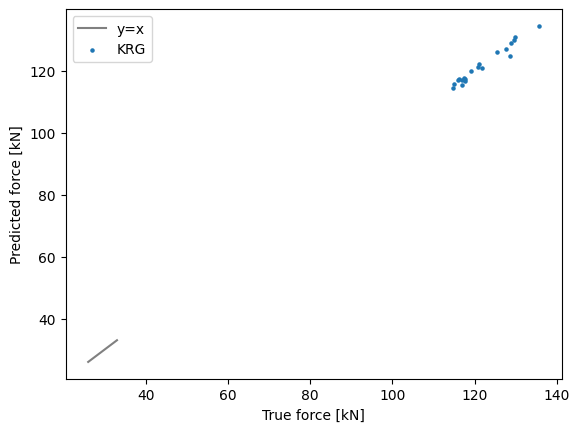

In [120]:
plt.plot([26,33], [26, 33], label='y=x', color='gray')

plt.scatter(Y_val, Y_pred, s=5, label='KRG', color='tab:blue')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()